# Современные методы распознавания и синтеза речи
## Практическое задание 1: Цифровые фильтры

В данном задании вам предстоит применить рассмотренные на лекциях линейные фильтры для задачи шумоподавления. Вы попробуете обнаружить вражеский самолет и узнать что за секретные данные он передавал.

In [1]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import wavfile
%matplotlib inline

# Auxiliary plotting functions for this task
from utils import plot_projections, scatter_trajectory, scatter_volume

### Часть 1. Поиск самолета

Англия, 1940 год. Британские военные налаживают систему радаров для раннего обнаружения вражеских самолетов. В один спокойный вечер вы обнаруживаете, что инженер, разрабатывавший радар, допустил программную ошибку и в текущий момент данные обрабатываются неправильно. Тем не менее, в воздухе только что пролетел вражеский самолет! Ваша задача — быстро исправить программный код радара, чтобы отследить траекторию самолета и уничтожить его до того, как тот нанесет удар по городу. Судьба Лондона в ваших руках!

На данный момент у вас имеются 20 сэмплов данных с радара, полученных с интервалом в 5 секунд. Каждый сэмпл — массив комплексных чисел 64x64x64, отражающих состояние окружающего пространства. Таким образом, единственное, что у вас есть — тензор размера 20x64x64x64 и орудие земля-воздух. При каждом измерении радара, самолет резонирует на определенной (неизвестной) частоте. Спектр такого сигнала будет напоминать гауссиану с центром в неизвестной точке. Так сложилось, что конкретную частоту вы не знаете (она зависит от модели самолета), что несколько усложняет задачу. Вторая проблема – плохие погодные условия создают сильные помехи, делающие получаемый сигнал неинтерпретируемым.

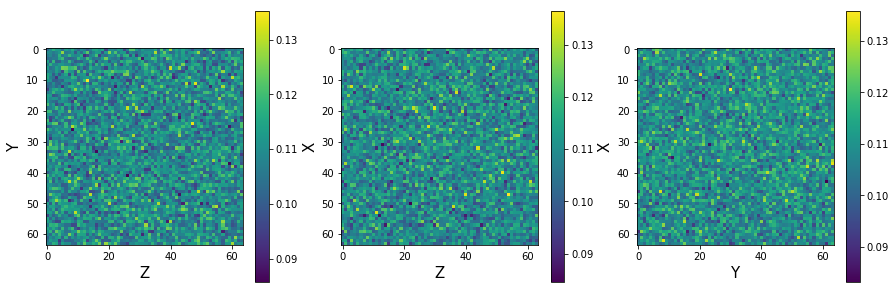

In [2]:
V = np.load('data/plane.npz')['plane']
plot_projections(np.abs(V.mean(0)))

### 1.1 Частота
Для начала попробуем понять на какой частоте находится искомый сигнал. Для этого вычислим 3D преобразование Фурье от нашего сигнала в каждый момент времени. На выходе мы получим 20 спектров. Важно учесть, что комлексный аргумент шумовой компоненты для каждого измерения различен. Полезный сигнал, однако, будет иметь одинаковый спектр. Таким образом, усредняя спектры по времени мы сможем найти искомую частоту, подавив шум. Усредните спектры и найдите искомую частоту (используйте функцию `fftn` для получения спектра). 

<i> Для самопроверки: yC=9</i>

In [3]:
mean_spectrum = fftn(V, axes=(1, 2, 3)).mean(axis=0)
xC, yC, zC = np.unravel_index(np.argmax(np.abs(mean_spectrum)), mean_spectrum.shape)

### 1.2 Построение фильтра
Теперь мы знаем частоту, вокруг которой надо фильтровать. Постройте Гауссов фильтр с центром в найденной частоте. Не забудьте учесть периодичность фильтра.

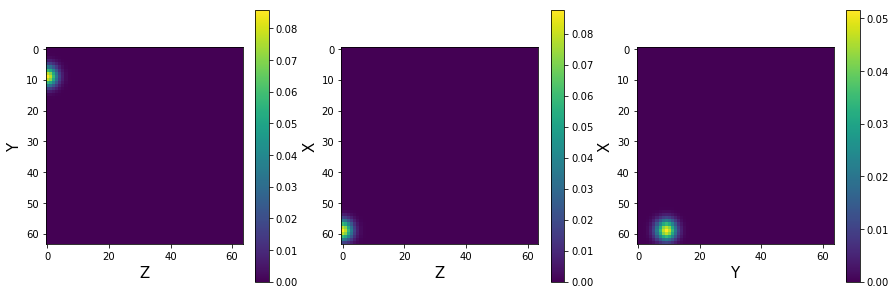

In [4]:
K = np.zeros((64, 64, 64))
x, y, z = np.indices((64, 64, 64))
k = 0.1
K = np.exp(-k * ((x - xC) ** 2 + (y - yC) ** 2 + (z - zC) ** 2))
plot_projections(K)

### 1.3 Фильтрация
Последний этап в обнаружении самолета — фильтрация сигнала. Вычислите спектр сигнала в каждый момент времени и домножте его на построенное ядро. Сделайте обратное преобразование Фурье (`ifftn`) и найдите координаты самолета. В какую координату надо запустить ракету?

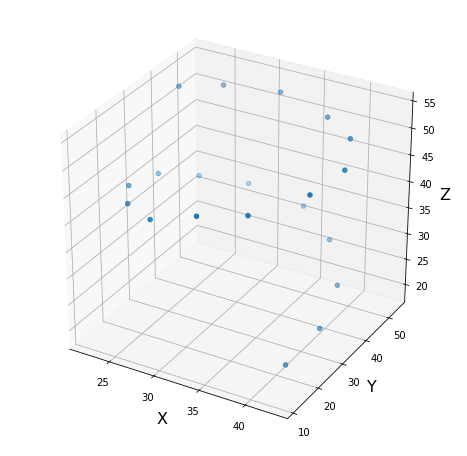

In [5]:
V_filtred = fftn(V, axes=(1, 2, 3)) * K
V_true = ifftn(V_filtred, axes=(1, 2, 3))
x, y, z = np.array([
    np.unravel_index(np.argmax(np.abs(v)), v.shape) 
    for v in V_true
]).T
scatter_trajectory(x, y, z)

# 2. Изображения

Итак, вам удалось сбить самолет. Однако, перед падением ему удалось отправить сигнал — зашифрованное изображение. При перехвате изображение сильно зашумилось и теперь вам придется попробовать подавить шум, чтобы узнать что же изображено на перехваченной картинке.

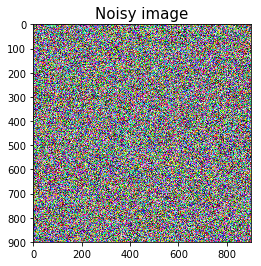

In [6]:
noisy_image = np.load('data/image.npz')['image']
plt.imshow(noisy_image, cmap=plt.cm.Greys_r)
plt.title('Noisy image', fontsize=15)

Отобразите спектр каналов изображения. Так как у естественных изображений обычно преобладает низкочастотная компонента, попробуем оставить только ее. Для этого постройте фильтр низких частот и примените его к каждому каналу. Наконец, отобразите полученное изображение.

<it>Замечание: для отображения спектра воспользуйтесь функциями `fftshift` и `ifftshift`, чтобы сдвинуть низкие частоты в центр массива.</it>

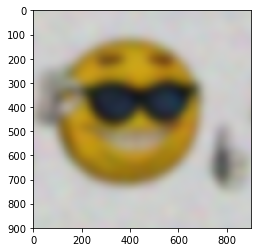

In [7]:
K = np.zeros(noisy_image.shape[:2])
xC, yC = np.array(noisy_image.shape[:2]) // 2
x, y = np.indices(noisy_image.shape[:2])
k = 0.01
K = np.exp(-k*((x - xC)**2 + (y - yC)**2))
K /= K.sum()
noisy_image_fft = fftshift(fftn(noisy_image, axes=(0, 1)), axes=(0, 1))*K[:, :, None]
plt.imshow(np.abs(ifftn(noisy_image_fft, axes=(0, 1))))

# 3. Импульсная характеристика

В третьей части задания мы попробуем применить аппарат линейных фильтров для наложения звуковых эффектов на звук. Возьмите с сайта <a href="http://www.openairlib.net">openairlib.net</a> запись голоса из <a href="http://www.openairlib.net/anechoicdb">безэховой камеры</a> (<a href="http://www.openairlib.net/anechoicdb">http://www.openairlib.net/anechoicdb</a>) и импульсную характеристику какого-нибудь здания (<a href="http://www.openairlib.net/auralizationdb">http://www.openairlib.net/auralizationdb</a>). Модифицируйте запись таким образом, чтобы голос звучал так, будто бы запись была сделана в выбранном здании. (Подсказка: используйте свертку).

<it>Замечание: будьте аккуратны с амплитудами — постарайтесь не оглохнуть. Также обратите внимание на sampling rate системы. Они должны быть одинаковыми как у импульсной характеристики, так и у записи голоса. В случае несовпадения примените downsampling к одной из записей.</it>

In [18]:
from scipy.signal import resample_poly, convolve, resample

In [19]:
IR_PATH = './sounds/ir1.wav'
SOUND_PATH = './sounds/b1-sc.wav'
IR_sample_rate, IR = wavfile.read(IR_PATH)
sound_sample_rate, sound = wavfile.read(SOUND_PATH)

/root/anaconda3/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [20]:
print("IR sample rate:", IR_sample_rate)
print("sound sample rate:", sound_sample_rate)

IR sample rate: 44100
sound sample rate: 96000


In [ ]:
sound = resample(sound, 50000)
IR = resample(IR, 50000)
modified_sound = convolve(sound, IR, mode='same')

In [ ]:
OUTPUT_PATH = "./sounds/output.wav"
sample_rate = IR_sample_rate
wavfile.write(OUTPUT_PATH, sample_rate, modified_sound.astype('int16'))

На проверку следует отправить заполненный Jupyter notebook, а также сгенерированные .wav файлы.